In [ ]:
!git clone https://github.com/seantyh/morphert

Cloning into 'morphert'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 1), reused 22 (delta 1), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [ ]:
!pip install -q --progress-bar off transformers umap-learn opencc hdbscan functorch
!pip install -U gensim





  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done






     |████████████████████████████████| 24.1 MB 94.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import sys
if "./morphert/src" not in sys.path:
  sys.path.append("./morphert/src")

In [ ]:
import pickle
from pathlib import Path
from itertools import groupby, combinations
from textwrap import wrap
from tqdm.auto import tqdm
from opencc import OpenCC

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from gensim.models import KeyedVectors
import umap
import hdbscan

import torch
from functorch import jacrev, jacfwd
from transformers import BertTokenizer, BertModel, BertPreTrainedModel
from morphert.model import *

In [ ]:
base_dir = Path("/content/drive/MyDrive/LangOn/morphert")
t2s = OpenCC("t2s").convert
with open(base_dir / "tencent_small_500k.pkl", "rb") as fin:
    (vocabs, embs) = pickle.load(fin)   

In [ ]:
N = 500000
with open(base_dir/"tencent_small_500k.pkl", "rb") as fin:
    (vocabs, embs) = pickle.load(fin)   
kv = KeyedVectors(100)
kv.add_vectors(vocabs, embs)
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = MorphertModel.from_pretrained(base_dir/"morphert_500k")
collator_fn = DataCollator(tokenizer)
model = model.to("cuda")
full_ds = MorphertDataset(np.arange(N), vocabs, embs)
full_emb = np.vstack([full_ds[i]["vec"] for i in range(N)])
in_tencent = lambda x: x in full_ds.vocabs

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [ ]:
tokenizer("電腦")

{'input_ids': [101, 7442, 5582, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
in_embeds = model.bert.embeddings.word_embeddings(torch.tensor([[101, 7442, 5582, 102]]).to("cuda"))
out_embeds = model(inputs_embeds=in_embeds)
out_tokens = model(**tokenizer("電腦", return_tensors="pt").to("cuda"))
torch.allclose(out_embeds.predictions, out_tokens.predictions)

True

In [ ]:
from torch.autograd.functional import jacobian
def compute_token_jacobian(tgt_word, tgt_loc, model, tokenizer):
    tgt_loc += 1  # offset the [CLS] token
    assert 1 <= tgt_loc <= len(tgt_word)
    tokens = tokenizer([tgt_word], return_tensors="pt").to("cuda")
    in_embeds = model.bert.embeddings.word_embeddings(tokens.input_ids)
    def partial_effect(x):        
        in_embeds[:,tgt_loc,:] = x
        out = model(inputs_embeds=in_embeds)
        return out.predictions
    J = jacobian(partial_effect, in_embeds[:,tgt_loc,:])
    return J

In [ ]:
def compute_token_jacobian_functorch(tgt_word, model, tokenizer):    
    tokens = tokenizer([tgt_word], return_tensors="pt").to("cuda")    
    in_embeds = model.bert.embeddings.word_embeddings(tokens.input_ids)
    def partial_effect(x):                     
        out = model(inputs_embeds=x)
        return out.predictions
    J = jacrev(partial_effect, argnums=0)(in_embeds)
    return J

In [ ]:
t2s("老")

'老'

## Compute Chareme effect

In [ ]:
from collections import Counter
Counter("".join(vocabs[:50000])).most_common()[110:120]

[('综', 270),
 ('得', 267),
 ('龙', 264),
 ('女', 262),
 ('码', 261),
 ('力', 259),
 ('青', 259),
 ('用', 256),
 ('行', 253),
 ('站', 252)]

In [ ]:
MAX_SIZE = 300
tgt_char = "行"
c1_set = [(x,0) for x in vocabs[:50000] 
          if len(x)==2 and x[0] in (tgt_char, t2s(tgt_char))]
c2_set = [(x,1) for x in vocabs[:50000] 
          if len(x)==2 and x[1] in (tgt_char, t2s(tgt_char))]
cx_set = c1_set + c2_set
# cx_set = c1_set
del c1_set, c2_set
print("original size: ", len(cx_set))
if len(cx_set) > MAX_SIZE:
  cx_set = cx_set[:MAX_SIZE]
  print("reduced size: ", len(cx_set))

original size:  109


In [ ]:
bisyll_set = [x for x in vocabs[:50000] if len(x)==2]
bisyll_Js = {}
for word, loc in tqdm(bisyll_set):
    J = compute_token_jacobian_functorch(word, model, tokenizer).squeeze().detach().cpu().numpy()
    # subset the second token (the first character, considering the [CLS] offset)
    bisyll_Js[word] = J[:,1:3,:]
with open(base_dir / "bisyll_Js_in50k.pkl", "wb") as fout:
  pickle.dump(bisyll_Js, fout)

  0%|          | 0/25039 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:277: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::infinitely_differentiable_gelu_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /__w/functorch/functorch/functorch/csrc/BatchedFallback.cpp:85.)
  allow_unused, accumulate_grad=False)  # Calls into the C++ engine to run the backward pass


In [ ]:
bisyll_Js["行为"].shape

(100, 2, 768)

In [ ]:
Js = []
for word, loc in tqdm(cx_set):
    J = compute_token_jacobian_functorch(word, model, tokenizer).squeeze().detach().cpu().numpy()
    # subset the second token (the first character, considering the [CLS] offset)
    Js.append(J[:,loc+1,:])

  0%|          | 0/109 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:277: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::infinitely_differentiable_gelu_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /__w/functorch/functorch/functorch/csrc/BatchedFallback.cpp:85.)
  allow_unused, accumulate_grad=False)  # Calls into the C++ engine to run the backward pass


In [ ]:

distJ = np.zeros((len(Js), len(Js)))
for i, j in combinations(range(len(Js)), 2):
    # L2norm = np.sqrt(((Js[i] - Js[j])**2).sum())
    L1norm = np.abs(Js[i] - Js[j]).sum()
    distJ[i,j] = distJ[j,i] = L1norm
distJ.shape

(109, 109)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


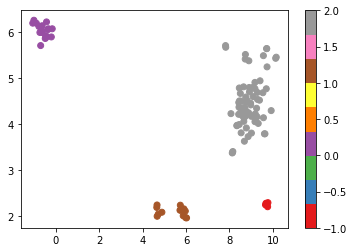

In [ ]:
umap_inst = umap.UMAP(n_components=5, metric="precomputed", n_neighbors=2, random_state=24)
proj = umap_inst.fit_transform(distJ)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
clusterer.fit(proj)
clust_idxs = clusterer.labels_
plt.scatter(proj[:,0],proj[:,1],c=clust_idxs,cmap="Set1")
plt.colorbar()

In [ ]:
clust_groups = {}
for obs_i, clust_idx in enumerate(clust_idxs):
  clust_groups.setdefault(clust_idx, []).append(obs_i)

for clust_i in sorted(list(clust_groups.keys())):
  members = clust_groups[clust_i]
  print(f"--- {clust_i} ---")
  print(*wrap(" ".join(cx_set[x][0] for x in members)), sep="\n")

--- -1 ---
行驶 行走 行车 行进
--- 0 ---
行了 行的 行吗 行不 行会 不行 就行 自行 才行 一行 前行 还行 也行 可行 都行 先行 再行 中行 另行
--- 1 ---
进行 举行 实行 流行 履行 推行 施行 盛行 现行 進行 奉行 试行 例行
--- 2 ---
行为 行业 行动 行情 行程 行人 行列 行李 行政 行星 行使 行事 行礼 行货 行踪 行长 行径 行家 行者 行道 行至 银行 运行
执行 发行 旅行 出行 同行 强行 央行 飞行 修行 排行 践行 通行 步行 下行 五行 上行 平行 支行 骑行 逆行 该行 工行 建行
农行 言行 分行 罪行 航行 绕行 转行 游行 穿行 开行 此行 德行 随行 并行 风行 横行 商行 放行 入行 爬行 投行 送行 远行
品行 这行 车行 人行


In [ ]:
## nearest neighbors
tgt_probe = t2s("实行")
distP = squareform(pdist(proj))
tidx = [x[0] for x in cx_set].index(tgt_probe)
neigh_idxs = np.argsort(distJ[tidx,:])[:11]
print("chareme: ", [cx_set[i][0] for i in neigh_idxs])
print("wordvec: ", [x[0] for x in kv.most_similar(tgt_probe, topn=100) if len(x[0])==2][:10])

chareme:  ['实行', '進行', '银行', '进行', '就行', '运行', '履行', '行吗', '还行', '也行', '举行']
wordvec:  ['实施', '推行', '施行', '统一', '制度', '改革', '采取', '现行', '颁布', '政策']


## Compare with word embeddings

In [ ]:
emb_t = [embs[vocabs.index(x[0]), :] for x in cx_set]
umap_t = umap.UMAP(metric="cosine", n_neighbors=2)
proj_t = umap_t.fit_transform(emb_t)

--- -1 ---
十分 高分 加分 万分
--- 0 ---
成分 水分 养分 糖分 瓜分 平分
--- 1 ---
部分 划分 区分 可分 的分 细分 不分 拆分 被分
--- 2 ---
积分 得分 比分 评分 满分 3分 打分 总分 6分 4分 上分 8分 7分 9分 学分 跑分
--- 3 ---
充分 过分 缘分 天分 本分 身分
--- 4 ---
三分 几分 一分 时分 公分 两分 中分 五分 半分 七分
--- 5 ---
5分 2分 1分 处分 扣分 0分


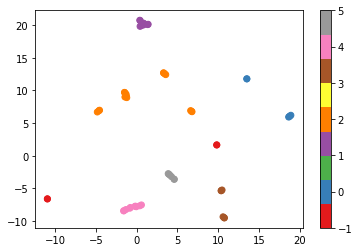

In [ ]:
clusterer_t = hdbscan.HDBSCAN(min_cluster_size=5)
clusterer_t.fit(proj_t)
clust_idxs_t = clusterer_t.labels_
plt.scatter(proj_t[:,0],proj_t[:,1],c=clust_idxs_t,cmap="Set1")
plt.colorbar()

clust_groups_t = {}
for obs_i, clust_idx_t in enumerate(clust_idxs_t):
  clust_groups_t.setdefault(clust_idx_t, []).append(obs_i)

for clust_i in sorted(list(clust_groups_t.keys())):
  members = clust_groups_t[clust_i]
  print(f"--- {clust_i} ---")
  print(*wrap(" ".join(cx_set[x][0] for x in members)), sep="\n")

## Good Examples

### 手

```
--- -1 ---
手中 手里 手上 手下 手镯 手链 手环 手袋 右手 左手
--- 0 ---
手指 手掌 手持 手握 手笔 手背
--- 1 ---
手臂 手感 手腕 手套 手脚 手势 手柄 手枪 手淫 手提 手雷 手部
--- 2 ---
伸手 挥手 抬手 举手 招手 拱手 转手 摆手
--- 3 ---
手机 手术 手游 手续 手动 手表 手工 手艺 手办 手册 手稿
--- 4 ---
手法 手摸 对手 双手 一手 亲手 随手 顺手 握手 人手 两手 反手 鬼手 触手 扶手 单手 好手 老手 打手 徒手 水手
--- 5 ---
手头 手心 手拿 的手 用手 把手 小手 洗手 大手 了手 先手 将手 还手 拿手 我手 起手 后手
--- 6 ---
选手 歌手 射手 枪手 车手 骑手 棋手 牌手
--- 7 ---
手段 手绘 手写 手牌 高手 分手 出手 入手 新手 携手 联手 动手 二手 快手 下手 着手 杀手 助手 到手 交手 牵手 上手 接手
放手 凶手 抓手 得手 插手 帮手 身手 纲手 棘手 失手 拉手 剁手 抢手
```